In [1]:
# Required imports
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.cluster import KMeans

## Load the Data Into a Pandas DataFrame

In [2]:
# Read in the CSV file as a Pandas Dataframe
ccinfo_default_df = pd.read_csv(
    Path("../Resources/ccinfo_transformed_no_dummies_only_cust_segm.csv")
)

ccinfo_default_df.head()

,limit_bal,age,bill_amt,pay_amt,customer_segments
0,-1.117341,24,-0.660703,-0.542779,2
1,-0.349942,26,-0.636370,-0.463994,2
2,-0.580162,34,-0.416808,-0.354013,0
3,-0.887121,37,-0.080152,-0.402077,0
4,-0.887121,57,-0.396855,0.523771,1


In [3]:
# Plot the clusters using the "limit_bal" and "age" columns
ccinfo_default_df.hvplot.scatter(
    x="limit_bal",
    y="age",
    by="customer_segments"
)

:NdOverlay   [customer_segments]
   :Scatter   [limit_bal]   (age)

In [4]:
# Plot the clusters using the "bill_amt" and "pay_amt" columns
ccinfo_default_df.hvplot.scatter(
    x="bill_amt",
    y="pay_amt",
    by="customer_segments"
)

:NdOverlay   [customer_segments]
   :Scatter   [bill_amt]   (pay_amt)

## Use PCA to reduce the number of factors 

In [5]:
# Remove the Customer Segments variable, add inplace=True
ccinfo_default_df.drop(columns="customer_segments", inplace=True)

In [6]:
#Import Stadardscaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

In [7]:
# Use the StandardScaler module and fit_transform function to 
# scale all columns with numerical values
#ccinfo_default_df.loc[:,'age'] = StandardScaler().fit_transform(ccinfo_default_df[['age']])
ccinfo_default_lst = StandardScaler().fit_transform(ccinfo_default_df)

In [8]:
# Create a DataFrame called with the scaled data
# The column names should match those referenced in the StandardScaler step
ccinfo_default_df_scaled = pd.DataFrame(
    ccinfo_default_lst,
    columns=["limit_bal", "age", "bill_amt", "pay_amt"])
ccinfo_default_df_scaled.head()

,limit_bal,age,bill_amt,pay_amt
0,-1.117341,-1.226792,-0.660703,-0.542779
1,-0.349942,-1.010942,-0.636370,-0.463994
2,-0.580162,-0.147541,-0.416808,-0.354013
3,-0.887121,0.176234,-0.080152,-0.402077
4,-0.887121,2.334734,-0.396855,0.523771


In [9]:
# Import the PCA module
from sklearn.decomposition import PCA

In [10]:
# Instantiate the PCA instance and declare the number of PCA variables
pca = PCA(n_components=2)

In [11]:
# Fit the PCA model on the transformed credit card DataFrame
ccinfo_pca = pca.fit_transform(ccinfo_default_df)

# Review the first 5 rows of list data
ccinfo_pca[:5]

array([[-11.39374532,  -1.11578252],
       [ -9.37955678,  -0.65786695],
       [ -1.38301701,  -0.75048925],
       [  1.61282554,  -0.82015925],
       [ 21.61349307,  -0.82424692]])

## PCA explained variance ratio

In [12]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.96665303, 0.01914715])

## Creating the PCA DataFrame

In [13]:
# Create the PCA DataFrame
ccinfo_pca_df = pd.DataFrame(
    ccinfo_pca,
    columns=["PCA1", "PCA2"]
)

# Review the PCA DataFrame
ccinfo_pca_df.head()

,PCA1,PCA2
0,-11.393745,-1.115783
1,-9.379557,-0.657867
2,-1.383017,-0.750489
3,1.612826,-0.820159
4,21.613493,-0.824247


## Display the weights of each feature in the corresponding principal component
#### Higher value indicate stronger influecne of that future on the principal compoent

In [14]:
import numpy as np
# Get the absolute values of the PCA components
pca_components_abs = np.abs(pca.components_)

# Create a DataFrame to represent the weights of each original feature in the principal components
pca_weights_df = pd.DataFrame(pca_components_abs, columns=ccinfo_default_df.columns, index=['PC1', 'PC2'])

# Display the DataFrame showing the weights of each original feature in the principal components
pca_weights_df

,limit_bal,age,bill_amt,pay_amt
PC1,0.018021,0.999781,0.007167,0.007912
PC2,0.566803,0.019010,0.564838,0.599442


## Visual Representation using a heat map of the weights of the original features in the principal components

In [20]:
# Assuming pca_weights_df is your DataFrame containing weights
heatmap = pca_weights_df.hvplot.heatmap(
    xlabel='Features', 
    ylabel='Principal Components',
    title='Weights of Original Features in Principal Components',
    cmap='coolwarm',
    width=700,
    height=500
)

heatmap


:HeatMap   [columns,index]   (value)

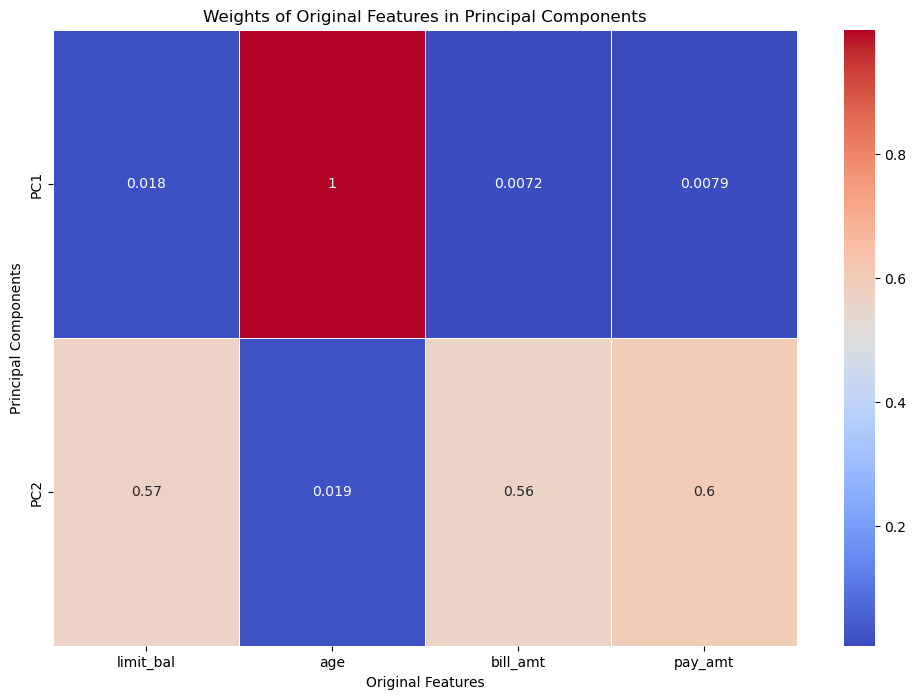

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the heatmap
# sns.set(style="whitegrid")

# Create a heatmap of the PCA weights
plt.figure(figsize=(12, 8))
sns.heatmap(pca_weights_df, annot=True, cmap="coolwarm", linewidths=.5)
plt.title('Weights of Original Features in Principal Components')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()


### Why PC2 has equally weights in three features? What to do next?
If for PC2 three features are almost equally weighted, it implies that these features contribute approximately equally to PC2 and may have similar relationships with each other in the original dataset. In such cases, it's essential to analyze the relationships between these features and their impact on the principal component.

### So, what to do next?
Consider doing the following:
1. Explore Feature Relationships --> Investigate the relationships between the features that have similar weights in PC2. You can use correlation matrices, scatter plots, or pair plots to visualize the relationships and identify any patterns or dependencies.
2. Domain Knowledge --> Leverage subject matter expertise to understand why these features might be equally weighted in PC2.
3. Feature Selection or Dimensionality Reduction --> If the features are highly correlated or provide redundant information, you may consider performing feature selection techniques or applying different dimensionality reduction methods to reduce the number of features and improve model interpretability.

## Incorporating the PCA DataFrame into the elbow method

In [16]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Append the value of the computed inertia from the `inertia_` attribute of teh KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(ccinfo_pca_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,437869.195089
1,2,141639.613200
2,3,72111.650387
3,4,51726.474368
4,5,34740.924849


In [17]:
# Plot the Elbow Curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

## Segmention of the PCA data with Kmeans 

In [18]:
# Define the model with 3 clusters
model = KMeans(n_clusters=3, random_state=0)

# Fit the model
model.fit(ccinfo_pca_df)

# Make predictions
k_3 = model.predict(ccinfo_pca_df)

# Create a copy of the PCA DataFrame
ccinfo_pca_predictions_df = ccinfo_pca_df.copy()

# Add a class column with the labels
ccinfo_pca_predictions_df["customer_segments"] = k_3

In [19]:
# Plot the clusters
ccinfo_pca_predictions_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="customer_segments"
)

:NdOverlay   [customer_segments]
   :Scatter   [PCA1]   (PCA2)